# Training the Lunar Lander RL System

In [1]:
# import package dependencies
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from rl_glue import RLGlue
from environment import BaseEnvironment
from lunar_lander import LunarLanderEnvironment
from agent import BaseAgent
from collections import deque
from copy import deepcopy
from tqdm import tqdm
import os 
import shutil
from plot_script import plot_result

In [2]:
# import classes and functions in RL_system
from RL_system import Agent, ActionValueNetwork, softmax, ReplayBuffer, Adam, get_td_error, optimize_network

## Experiment

In [3]:
def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):
    
    rl_glue = RLGlue(environment, agent)
        
    # save sum of reward at the end of each episode
    agent_sum_reward = np.zeros((experiment_parameters["num_runs"], 
                                 experiment_parameters["num_episodes"]))

    env_info = {}

    agent_info = agent_parameters

    # one agent setting
    for run in range(1, experiment_parameters["num_runs"]+1):
        agent_info["seed"] = run
        agent_info["network_config"]["seed"] = run
        env_info["seed"] = run

        rl_glue.rl_init(agent_info, env_info)
        
        for episode in tqdm(range(1, experiment_parameters["num_episodes"]+1)):
            # run episode
            rl_glue.rl_episode(experiment_parameters["timeout"])
            
            episode_reward = rl_glue.rl_agent_message("get_sum_reward")
            agent_sum_reward[run - 1, episode - 1] = episode_reward
    save_name = "{}".format(rl_glue.agent.name)
    if not os.path.exists('results'):
        os.makedirs('results')
    np.save("results/sum_reward_{}".format(save_name), agent_sum_reward)
    shutil.make_archive('results', 'zip', 'results')

    return rl_glue

# Experiment parameters
experiment_parameters = {
    "num_runs" : 1,
    "num_episodes" : 300,
    # OpenAI Gym environments allow for a timestep limit timeout, causing episodes to end after 
    # some number of timesteps. Here we use the default of 500.
    "timeout" : 500
}

# Environment parameters
environment_parameters = {}

current_env = LunarLanderEnvironment

# Agent parameters
agent_parameters = {
    'network_config': {
        'state_dim': 8,
        'num_hidden_units': 256,
        'num_actions': 4
    },
    'optimizer_config': {
        'step_size': 1e-3,
        'beta_m': 0.9, 
        'beta_v': 0.999,
        'epsilon': 1e-8
    },
    'replay_buffer_size': 50000,
    'minibatch_sz': 8,
    'num_replay_updates_per_step': 4,
    'gamma': 0.99,
    'tau': 0.001
}
current_agent = Agent

In [4]:
# run experiment
rl_glue = run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [20:24<00:00,  4.08s/it]


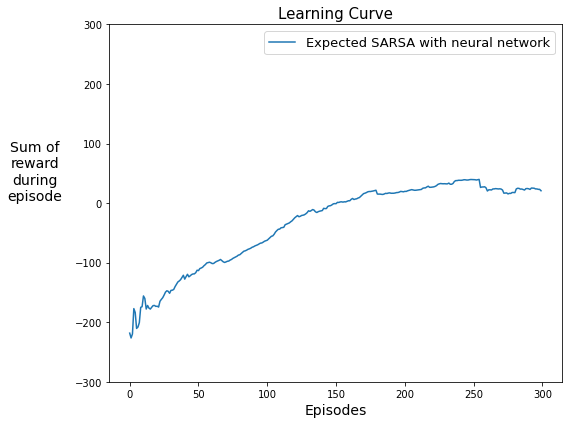

In [5]:
plot_result(["expected_sarsa_agent"])

## Run Agent in Environment

In [6]:
import gym

In [7]:
# initialize environment
env = gym.make('LunarLander-v2')

# get trained agent
agent = rl_glue.agent

# initialize environment
observation = env.reset()

for t in range(1000):
    # render environment
    env.render()
    
    # get action from agent
    action = agent.policy(observation)
    
    # act on environment and get next state
    observation, reward, done, info = env.step(action)
    
    if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    
env.close()

Episode finished after 339 timesteps
